# Nifty 50 Options EDA 

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# Set plot styles
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

In [23]:
df = pd.read_csv("../data/option_chain.csv")


In [27]:
# Convert date columns
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Simulate expiryDate (7 days ahead)
df['expiryDate'] = df['timestamp'] + pd.Timedelta(days=7)
df['days_to_expiry'] = (df['expiryDate'] - df['timestamp']).dt.days

# Drop NaNs in key columns
df.dropna(subset=['impliedVolatility', 'openInterest', 'lastPrice', 'strikePrice'], inplace=True)

# Ensure correct dtypes
df['strikePrice'] = pd.to_numeric(df['strikePrice'], errors='coerce')
df['impliedVolatility'] = pd.to_numeric(df['impliedVolatility'], errors='coerce')
df['openInterest'] = pd.to_numeric(df['openInterest'], errors='coerce')
df['lastPrice'] = pd.to_numeric(df['lastPrice'], errors='coerce')

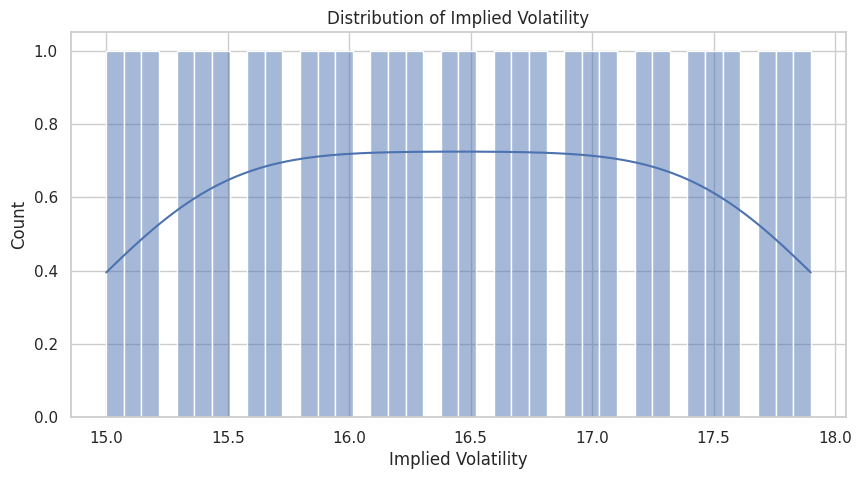

In [28]:
# --- 1. Distribution of Implied Volatility ---
plt.figure()
sns.histplot(df['impliedVolatility'], bins=40, kde=True)
plt.title("Distribution of Implied Volatility")
plt.xlabel("Implied Volatility")
plt.show()

In [31]:
# --- 2. OI vs IV Scatter ---
print(df.columns.tolist())


['timestamp', 'strikePrice', 'optionType', 'lastPrice', 'openInterest', 'impliedVolatility', 'delta', 'theta', 'vega', 'expiryDate', 'days_to_expiry']


In [32]:
# If strikePrice is duplicated for CE/PE, infer from symbol or instrument field
if 'instrumentType' in df.columns:
    df['type'] = df['instrumentType']
elif 'symbol' in df.columns:
    df['type'] = df['symbol'].apply(lambda x: 'CE' if 'CE' in x else ('PE' if 'PE' in x else 'Unknown'))
else:
    # Manual assumption (if all data is CE or PE)
    df['type'] = 'CE'  # or 'PE'


In [10]:
df = pd.read_csv("../data/option_chain.csv")


In [33]:
# If strikePrice is duplicated for CE/PE, infer from symbol or instrument field
if 'instrumentType' in df.columns:
    df['type'] = df['instrumentType']
elif 'symbol' in df.columns:
    df['type'] = df['symbol'].apply(lambda x: 'CE' if 'CE' in x else ('PE' if 'PE' in x else 'Unknown'))
else:
    # Manual assumption (if all data is CE or PE)
    df['type'] = 'CE'  # or 'PE'


In [34]:
df['type'] = df['type'].astype('category')


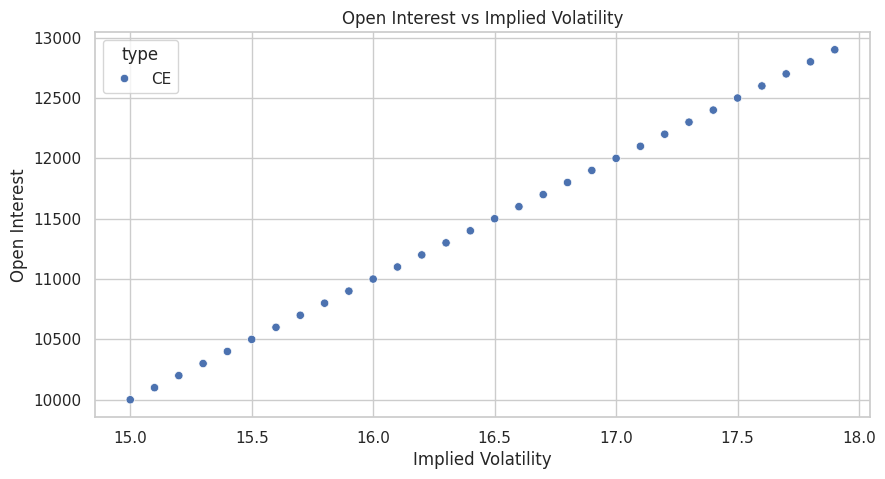

In [35]:
plt.figure()
sns.scatterplot(data=df, x='impliedVolatility', y='openInterest', hue='type')
plt.title("Open Interest vs Implied Volatility")
plt.xlabel("Implied Volatility")
plt.ylabel("Open Interest")
plt.show()


/tmp/ipykernel_15759/4028004123.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_oi = df.pivot_table(index='strikePrice', columns='type', values='openInterest', aggfunc='sum')


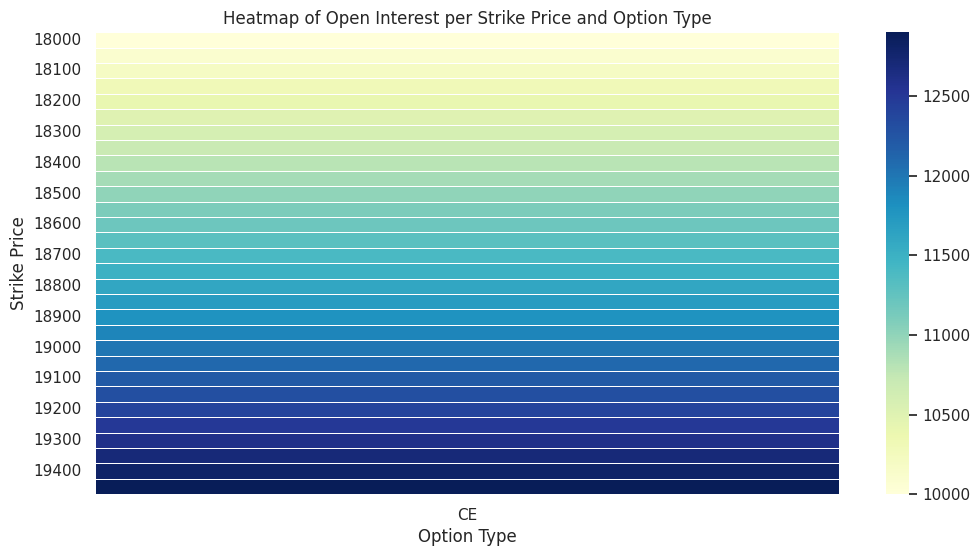

In [36]:
# --- 3. Heatmap: OI by Strike and Type ---
pivot_oi = df.pivot_table(index='strikePrice', columns='type', values='openInterest', aggfunc='sum')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_oi, annot=False, cmap='YlGnBu', linewidths=0.5)
plt.title("Heatmap of Open Interest per Strike Price and Option Type")
plt.xlabel("Option Type")
plt.ylabel("Strike Price")
plt.show()

/tmp/ipykernel_15759/1755517477.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_ltp, x='expiryDate', y='lastPrice', palette='coolwarm')


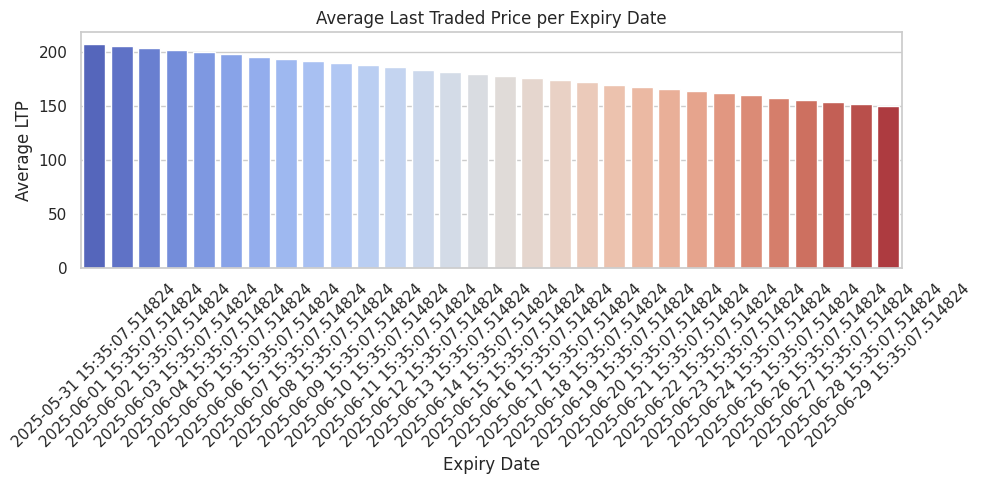

In [37]:
# --- 4. Average LTP per Expiry ---
avg_ltp = df.groupby('expiryDate')['lastPrice'].mean().reset_index()
plt.figure()
sns.barplot(data=avg_ltp, x='expiryDate', y='lastPrice', palette='coolwarm')
plt.title("Average Last Traded Price per Expiry Date")
plt.xlabel("Expiry Date")
plt.ylabel("Average LTP")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### *Implementing Machine Learning on the Nifty 50 options data*

Predict whether an option has high implied volatility (IV) based on features like strike price, open interest, LTP, etc.
We'll build a binary classifier (High IV vs Low IV) using a RandomForestClassifier.

In [38]:
#  imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:

# Load and preprocess data
df = pd.read_csv("../data/option_chain.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['expiryDate'] = df['timestamp'] + pd.Timedelta(days=7)
df['days_to_expiry'] = (df['expiryDate'] - df['timestamp']).dt.days

In [40]:
# Clean missing values
df = df.dropna(subset=['impliedVolatility', 'openInterest', 'lastPrice', 'strikePrice'])
df = df[(df['impliedVolatility'] > 0) & (df['openInterest'] > 0)]

In [41]:
# Binary target: High vs Low IV (median split)
threshold = df['impliedVolatility'].median()
df['high_iv'] = (df['impliedVolatility'] > threshold).astype(int)

In [46]:
print(df.columns)


Index(['timestamp', 'strikePrice', 'optionType', 'lastPrice', 'openInterest',
       'impliedVolatility', 'delta', 'theta', 'vega', 'expiryDate',
       'days_to_expiry', 'high_iv'],
      dtype='object')


In [47]:
# Example: Assuming you only loaded Call options data
df['type'] = 'CE'  # or 'PE'


In [48]:
df['type'] = 0  # For CE
# OR
df['type'] = 1  # For PE


In [49]:
# Show first few rows to see what the structure looks like
print(df.head())


                   timestamp  strikePrice optionType  lastPrice  openInterest  \
0 2025-06-22 15:35:07.514824        18000         CE        150         10000   
1 2025-06-21 15:35:07.514824        18050         CE        152         10100   
2 2025-06-20 15:35:07.514824        18100         CE        154         10200   
3 2025-06-19 15:35:07.514824        18150         CE        156         10300   
4 2025-06-18 15:35:07.514824        18200         CE        158         10400   

   impliedVolatility  delta  theta  vega                 expiryDate  \
0               15.0   0.40  -3.00  0.10 2025-06-29 15:35:07.514824   
1               15.1   0.41  -2.95  0.11 2025-06-28 15:35:07.514824   
2               15.2   0.42  -2.90  0.12 2025-06-27 15:35:07.514824   
3               15.3   0.43  -2.85  0.13 2025-06-26 15:35:07.514824   
4               15.4   0.44  -2.80  0.14 2025-06-25 15:35:07.514824   

   days_to_expiry  high_iv  type  
0               7        0     1  
1               

In [50]:
## Improved 'type' extraction and encoding block
# 🏷️ Step 1: Derive 'type' (Call/Put) from 'symbol' if 'type' is missing
if 'type' not in df.columns:
    if 'symbol' in df.columns:
        # Check and extract option type from the symbol string
        df['type'] = df['symbol'].apply(
            lambda x: 'CE' if 'CE' in str(x) else ('PE' if 'PE' in str(x) else 'UNK')
        )
    else:
        raise ValueError("Both 'type' and 'symbol' columns are missing!")

# ✅ Step 2: Keep only valid rows (Call/Put options)
df = df[df['type'].isin(['CE', 'PE'])].copy()

# 🔄 Step 3: Encode 'type' as binary: CE → 0, PE → 1
df['type'] = df['type'].map({'CE': 0, 'PE': 1})


In [53]:
# Features and Target
features = ['strikePrice', 'openInterest', 'lastPrice', 'days_to_expiry', 'type']
target = 'high_iv'

X = df[features]
y = df[target]

In [ ]:
for col in X.columns:
    if not pd.api.types.is_numeric_dtype(X[col]):
        print(f" Column '{col}' is not numeric.")


In [63]:
print("Original shape:", X.shape)
print("Numeric converted shape:", X_numeric.shape)
print("After dropping NaNs:", X_clean.shape)
print("NaN count per column:\n", X_numeric.isna().sum())


Original shape: (0, 5)
Numeric converted shape: (0, 5)
After dropping NaNs: (0, 5)
NaN count per column:
 strikePrice       0
openInterest      0
lastPrice         0
days_to_expiry    0
type              0
dtype: int64


In [76]:
features = ['strikePrice', 'openInterest', 'lastPrice', 'days_to_expiry', 'type']


In [77]:
print(df.columns)  # Confirm all required columns exist


Index(['timestamp', 'strikePrice', 'optionType', 'lastPrice', 'openInterest',
       'impliedVolatility', 'delta', 'theta', 'vega', 'expiryDate',
       'days_to_expiry', 'high_iv'],
      dtype='object')


In [88]:
#  Handle date
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['expiryDate'] = df['timestamp'] + pd.Timedelta(days=7)
df['days_to_expiry'] = (df['expiryDate'] - df['timestamp']).dt.days


In [90]:
# clean data
df = df.dropna(subset=['impliedVolatility', 'openInterest', 'lastPrice', 'strikePrice', 'timestamp'])
df = df[(df['impliedVolatility'] > 0) & (df['openInterest'] > 0)]


In [91]:

# Binary classification target: High vs Low IV
threshold = df['impliedVolatility'].median()
df['high_iv'] = (df['impliedVolatility'] > threshold).astype(int)

In [92]:
# Features and Target (No 'type')
features = ['strikePrice', 'openInterest', 'lastPrice', 'days_to_expiry']
target = 'high_iv'

X = df[features]
y = df[target]

In [93]:
#  Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [94]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [95]:
# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [96]:
# Evaluation
y_pred = model.predict(X_test)
print("📈 Classification Report:")
print(classification_report(y_test, y_pred))

📈 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



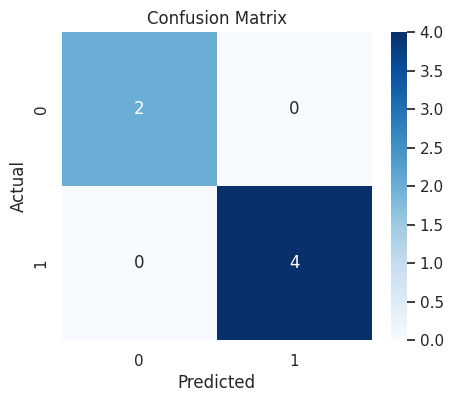

In [97]:
#  Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [99]:
# Feature importance plot
importances = model.feature_importances_
feat_names = features

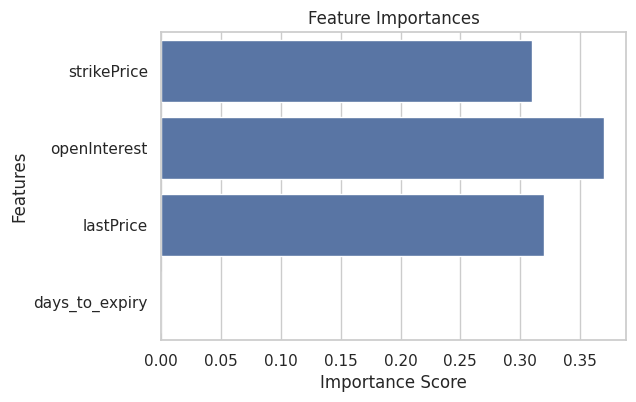

In [100]:
plt.figure(figsize=(6, 4))
sns.barplot(x=importances, y=feat_names)
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

In [104]:
# Save model
import joblib
joblib.dump(model, "/data/nifty_rf_model.joblib")
joblib.dump(scaler, "/data/scaler.joblib")
print("✅ Model and scaler saved as `nifty_rf_model.joblib` and `scaler.joblib`")

FileNotFoundError: [Errno 2] No such file or directory: '/data/nifty_rf_model.joblib'

In [105]:
import os
os.makedirs("data", exist_ok=True)

joblib.dump(model, "data/nifty_rf_model.joblib")
joblib.dump(scaler, "data/scaler.joblib")


['data/scaler.joblib']

In [107]:
import joblib

# Save to accessible directory in notebook
joblib.dump(model, "/data/nifty_rf_model.joblib")
joblib.dump(scaler, "/data/scaler.joblib")
print("✅ Model and scaler saved to /mnt/data/")


FileNotFoundError: [Errno 2] No such file or directory: '/data/nifty_rf_model.joblib'

In [112]:
import joblib

# Save model and scaler to valid path
joblib.dump(model, "nifty_rf_model.joblib")
joblib.dump(scaler, "scaler.joblib")

print("✅ Model and scaler saved to /notebooks/")


✅ Model and scaler saved to /notebooks/
